# Hull & White One Factor Model
------------------
> **Idriss Afra**

This project aims to implement the Hull & While One Factor model and apply it to price Bermudan Swaptions.

## Model Dynamics

The Hull-White One Factor model is a mono-curve short rate model. It assumes the following SDE :

$$dX_t = λ \left(\frac{Φ(t)}{λ} - X_t\right) dt + σ(t) dW_t$$

Where :    

- $X_t = r(t) - f(0, t) \text{}$, with $r_t$ being the short rate and $f(0, t)$ being the instantaneous forward rate $\left(X_0 = 0\right)$.

- $λ$ is the speed at which the short rate reverts to its long-term mean, i.e. the mean-reversion.
- $σ(t)$ is the short rate instantaneous volatility.
- $Φ(t) = ∫^{t}_{0} σ(s)^{2} e^{-2λ(t-s)} ds$ is seen as the short rate's total variance.

## Zero-Coupon Bond Hull-White Price

In the Hull-White One Factor model, the stochastic price of a zero-coupon bond at time $t$ with maturity $T$ is given by :     

$$
B(t, T) = E_t\left( e^{-∫_t^Tr_udu} \right) = \frac{B(0, T)}{B(0, t)} × EXP\left( -\frac{1}{2} × β(t, T)^{2} × Φ(t) - β(t, T) × X_t \right)
$$

Where :    

$$
β(t, T) = \frac{1 - e^{-λ (T-t)}}{λ}
$$

## European Swaption Hull-White Price

In the Hull-White One Factor model, an European swaption is priced by a replication of bond options. The present value of a payer or receiver swaption is given by : 

$$
PV_{HW}^{Pay/Rec} = B(0, T_0) × ∑_{i = 1}^{n}c_i × BS^{Put/Call}\left( T_{e}, K_i, \frac{B(0, T_i)}{B(0, T_0)}, σ_i \right)
$$

Where:
- $T_e$ is the swaption expiry, $T_0$ is the start date of the underlying swap, and $(T_i)_{1 ≤ i ≤ n}$ are the fixed leg payment dates of the the underlying swap

- $c_i = \delta_i \times K$ and $c_n = 1 + \delta_n \times K$, with $(\delta_i)_{i ≤ n}$ being the fixed leg day count fractions and $K$ being the swaption strike rate

- $BS$ : The Black-Scholes forward price formula

- $(K_i)_{i ≤ n}$ are the exercise frontiers : $∃! x_0 ∈ ℜ : K_i := \frac{B(T_{e}, T_i)(x_0)}{B(T_{e}, T_0)(x_0)} $, such as : $∑_{i = 1}^{n}c_iK_i = 1$

- $ σ_{i} = \sqrt{ \frac{Φ(T_e) × \left(e^{-λ(T_0-T_e)} - e^{-λ(T_i-T_e)}\right)^{2}}{λ^{2} T_e} }$ : The overall log-normal volatility of $\left( \frac{B(t, T_i)}{B(t, T_0)} \right)_t$ up to the expiry $T_e$

A detailed proof of derivation is available in the following document : [Hull-White 1F Model Analytics](https://github.com/Idriss-Afra/Hull-White-One-Factor-Model/blob/main/Hull-White%201F%20Model%20Analytics%20.pdf).

## Hull-White Model Calibration


To use the Hull-White one-factor model for pricing, two key parameters must be calibrated :

- $\lambda$: The mean-reversion rate.
- $\sigma(t)$: The time-dependent volatility of the short rate.

    Previously, the mean-reversion parameter was calibrated using Bermudan swaption market quotes. But as liquidity in that market declined, it became standard practice to fix $\lambda$ based on the rate market conditions. On the other hand, the volatility function $\sigma(t)$ is typically modeled as piecewise constant across the expiry dates of the instruments used in calibration (such as swaptions or caps/floors) to ensure a stable and simple process. In this project, the calibration basket consists of European swaptions.

### The Calibration Algorithm :     

#### The short rate total variance calibration :
- Set the initial total variance : $Φ(0) = 0$
- For each expiry $T_e$ in the calibration basket, solve $Φ(T_e)$ such that :

$$
PV_{HW}(Φ(T_e)) = Market  Price
$$

#### The short rate volatility stripping :
- Set a minimum volatility level : $σ_{min} = 0.0005$ (i.e., $5$ basis points).

For each expiry $T_i$ in the calibration basket : 
- If : $Φ(T_{i+1}) > Φ(T_i)×e^{-2λ(T_{i+1}-T_i)}$, then the short rate volatility over $[T_i, T_{i+1}[$ is stripped as :

$$σ_{i} = \sqrt{2λ×\frac{Φ(T_{i+1}) - Φ(T_i)×e^{-2λ(T_{i+1}-T_i)}}{1 - e^{-2λ(T_{i+1}-T{i})}}}$$
- Else, we floor the volatility : $σ_{i} = σ_{min}$, and then update the total variance accordingly :
$$
Φ(T_{i+1}) = Φ(T_i) × e^{-2λ(T_{i+1}-T_i)} + \frac{σ_{min}^{2}}{2λ}\left(1 - e^{-2λ(T_{i+1}-T_i)}\right)
$$


## Model Implementation

We first define a zero-coupon curve class to construct discounting curves :

In [1]:
import numpy as np
from scipy.interpolate import interp1d

class zc_curve :
    """
    Zero-Coupon Rate Curve class.
    """
    def __init__(self, maturities, zc_rates):
        """
        Init method : Takes the IR market tenors and the bootstrapped ZC rates.
        """
        self.maturities = maturities
        self.zc_rates = zc_rates
        # Cubic Interpolation & Extrapolation
        self.zc_rates_interp = interp1d(maturities, zc_rates, kind='cubic', fill_value="extrapolate")

    def df(self, T):
        """
        Zero-Coupon Discount Factors.
        """
        return np.exp(-self.zc_rates_interp(T)*T)

then, we implement the swaption instrument class :

In [2]:
from scipy.stats import norm

class swaption :
    """
    European Swaption class under the Normal (Bachelier) model.
    """
    def __init__(self, payer_receiver, expiry, tenor, strike, notional = 10000.):
        """
        Init method.
        """
        self.payer_receiver = payer_receiver
        self.expiry = expiry
        self.strike = strike
        self.notional = notional
        self.start_time = expiry + 2./365.
        # Fixed leg payment dates : Annually
        self.pay_times = np.arange(self.start_time + 1, expiry + tenor + 1)
        self.year_fractions = np.ones(len(self.pay_times))

    def set_market_data(self, df, normal_vol):
        """
        Stores DFs values to save computation time.
        """
        self.df_exp_time = df(self.expiry)
        self.df_start_time = df(self.start_time)
        self.df_pay_times = df(self.pay_times)
        self.normal_vol = normal_vol

    def level(self) :
      """
      The level function : Sum of DCF(T(i)) * B(0, T(i)) where T(i) are the fixed leg pay dates.
      """
      return np.sum(self.df_pay_times * self.year_fractions)

    def forward(self):
        """
        The forward level of the swap rate.
        """
        return (self.df_start_time - self.df_pay_times[-1]) / self.level()

    def pv_underlying(self):
        """
        PV of the underlying swap (No optionality).
        """
        phi = 1. if (self.payer_receiver.upper()=='PAYER') else -1.
        return phi * self.notional * self.level() * (self.forward() - self.strike)

    def market_price(self):
        """
        Swaption price under the Normal model.
        """
        phi = 1 if (self.payer_receiver.upper()=='PAYER') else -1
        lvl = self.level()
        fwd = self.forward()
        if (self.expiry==0 or self.normal_vol==0) : return max(phi * (fwd - self.strike), 0)
        sqrt_V2T = self.normal_vol * math.sqrt(self.expiry)
        d = (fwd - self.strike) / sqrt_V2T
        return self.notional * lvl * sqrt_V2T * (phi * d * norm.cdf(phi * d) + norm.pdf(d))


Finally, we develop the Hull-White One Factor model :

In [3]:
import math
from scipy import optimize
import matplotlib.pyplot as plt

class hw1f_model :
    """
    Hull & White 1F model, with a calibration based on European Swaptions.
    """
    def __init__(self, mean_reversion = 0.02, t = None, sigma_t = None):
        """
        Init method : 
        - t is a list of calibration instruments maturities
        - sigma_t is the instantaneous vol of the short rate (Piecewise constant)
        """
        self.mean_reversion = mean_reversion
        self.t = t
        self.sigma_t = sigma_t

    def price_from_phi(self, swopt, phi):
        """
        HW-1F swaption price using the input total variance phi.
        """
        Tf  = swopt.expiry
        T0  = swopt.start_time
        DF0 = swopt.df_start_time
        DFs = swopt.df_pay_times
        deltas = swopt.year_fractions

        # Bond options coefficients
        coefs = swopt.strike * deltas
        coefs[-1] += 1

        # Fwd Zero-Coupon Bond prices
        fwd_DFs = DFs / DF0

        # Beta functions computations
        beta0 = (1 - math.exp(-self.mean_reversion * (T0 - Tf))) / self.mean_reversion
        betas = (1 - np.exp(-self.mean_reversion * (swopt.pay_times - Tf))) / self.mean_reversion
        betas_minus_beta0 = betas - beta0
        betas2_minus_beta02 = betas**2 - beta0**2

        # Newton-Raphson algo functions to find the exercise frontier
        def f(x):
            return np.sum(coefs * fwd_DFs * np.exp(-0.5 * betas2_minus_beta02 * phi - betas_minus_beta0 * x)) - 1

        def f_deriv(x):
            return np.sum(- coefs * fwd_DFs * betas_minus_beta0 * np.exp(-0.5 * betas2_minus_beta02 * phi - betas_minus_beta0 * x))

        # The exponential Taylor expansion formula (up to the 1st order) to find the initial guess
        guess_x = (-1 + np.sum(coefs * fwd_DFs * (1 - 0.5 * betas2_minus_beta02 * phi))) / np.sum(coefs * fwd_DFs * betas_minus_beta0)

        # The exercise frontier
        x0 = optimize.newton(f, guess_x, f_deriv)

        # Bond options strikes
        strikes = fwd_DFs * np.exp(-0.5 * betas2_minus_beta02 * phi - betas_minus_beta0 * x0)

        # Bond options volatilities
        vols = math.sqrt(phi / Tf) * (math.exp(-self.mean_reversion * (T0 - Tf)) - np.exp(-self.mean_reversion * (swopt.pay_times - Tf))) / self.mean_reversion

        # Bond options flavors : Payer Swaption => Put Bond options || Receiver Swaption => Call Bond options
        phi = 1. if (swopt.payer_receiver.upper()=='PAYER') else -1.
        phi = - phi

        # Black formula of the Bond options
        d1 = (np.log(fwd_DFs / strikes) + 0.5 * vols**2 * Tf) / (vols * math.sqrt(Tf))
        d2 = d1 - vols * math.sqrt(Tf)
        bs_fwd = phi * fwd_DFs * norm.cdf(phi * d1) - phi * strikes * norm.cdf(phi* d2)

        # Hull-White swaption price
        return swopt.notional * DF0 * np.sum(coefs * bs_fwd)

    def calibrate_phi(self, instr):
        """
        NR Solver of the total variance Phi given a calibration instrument "instr".
        """
        market_price = instr.market_price()

        def f(phi):
            """
            HW-1F Price - Market (Normal) Price.
            """
            return self.price_from_phi(instr, phi) - market_price
        def f_deriv(phi):
            """
            Derivative function of f : Central Finite Difference method.
            """
            eps = 1e-06
            return (f(phi+eps) - f(phi-eps)) / (2.*eps)

        # Initial Guess : Thr normal total variance
        guess_phi = instr.normal_vol**2 * instr.expiry

        # We use the Newton-Raphson algorithm to calibrate the phi
        return optimize.newton(f, guess_phi, f_deriv)

    def calibrate_sigma(self, calib_set):
        """
        Calibration of sigma(t) term structure based on a set of instruments.
        """

        # 1st step : Calibrate Phi on different maturities
        phi = []
        for instr in calib_set:
            phi.append(self.calibrate_phi(instr))

        t = np.empty(len(calib_set)+1)
        sigma_t = np.empty(len(calib_set)+1)

        # Init values : Phi(t=0) = 0
        t[0] = 0;
        last_phi = 0

        # The minimum vol to consider : 0.05%
        sigma_min = 0.0005

        for i in range(len(calib_set)):
            t[i+1] = calib_set[i].expiry
            exp = math.exp(-2 * self.mean_reversion * (t[i+1] - t[i]))
            first_term = exp * last_phi

            # Negative sigma_t : Replace it with sigma_min and update the variance Phi accordingly
            if (phi[i] < first_term):
                sigma_t[i] = sigma_min
                phi[i] = first_term + sigma_min**2 * (1 - exp) / (2 * self.mean_reversion) # update phi accordingly
                print("HW-1F calibration : variance squeeze at step {}. Instrument [expiry = {} / tenor = {}] will be mispriced".format(i+1, calib_set[i].expiry, calib_set[i].pay_times[-1] - calib_set[i].start_time))
            # Positive sigma_t : Continue the calibration algorithm
            else :
                sigma_t[i] = math.sqrt(2 * self.mean_reversion * (phi[i] - first_term) / (1 - exp) )
                if (sigma_t[i] < sigma_min) :
                    sigma_t[i] = sigma_min
                    phi[i] = first_term + sigma_min**2 * (1 - exp) / (2 * self.mean_reversion)
                    print("HW-1F calibration : variance squeeze at step {}. Instrument [expiry = {} / tenor = {}] will be mispriced".format(i+1, calib_set[i].expiry, calib_set[i].pay_times[-1] - calib_set[i].start_time))

            last_phi = phi[i]

        # Flat extrapolation after the last maturity => Same size for t & sigma_t
        sigma_t[-1] = sigma_t[-2]

        # End of the calibration process : Store the calibration results in the class attributes
        self.t = t
        self.sigma_t = sigma_t

    def get_phi(self, t) :
        """
        Computes the total variance Phi up to maturities t.
        """
        # Add the array t to the maturities of the calibration instruments self.t => new_t
        new_t = np.append(self.t, t)
        new_t = np.delete(new_t, np.where(new_t > np.max(t)))
        new_t = np.unique(new_t)
        new_t = np.sort(new_t)

        # Phi values on new_t : self.sigma_t is piecewise constant on self.t
        sigma = interp1d(self.t, self.sigma_t, kind="previous", fill_value="extrapolate")
        sigma_new_t = sigma(new_t)
        phi_new_t = np.empty(len(new_t))
        phi_new_t[0] = 0
        exp_lambda_t = np.exp(2 * self.mean_reversion * new_t)
        for i in range(len(new_t) - 1) :
            phi_new_t[i+1] = (phi_new_t[i] * exp_lambda_t[i] + sigma_new_t[i]**2 * (exp_lambda_t[i+1] - exp_lambda_t[i]) / (2 * self.mean_reversion)) / exp_lambda_t[i+1]

        # Phi values on t
        phi_new_t = interp1d(new_t, phi_new_t, kind="previous", fill_value="extrapolate")
        return phi_new_t(t)

    def price(self, swopt):
        """
        HW-1F price of the swaption instrument "swopt".
        """
        t = np.array([swopt.expiry])
        phi = float(self.get_phi(t))
        return self.price_from_phi(swopt, phi)

    def print(self):
        """
        Prints the calibration details.
        """
        print("------------------------------------")
        print("HW-1F MODEL | Mean reversion = {:.2f}%\nVol sigma(t) (%) = ".format(self.mean_reversion*100.))
        for i in range(len(self.t)-1) :
            print("Short rate vol on [" + str(self.t[i]) + ", " + str(self.t[i+1]) + "[ : " + str(round(self.sigma_t[i] * 100, 4)) + "%")
        print("Then, flat extrapolation...")
        plt.title("HW Short Rate Volatility")
        plt.ylabel("HW Vol")
        plt.xlabel("Time")
        x_axis = np.linspace(0, self.t[-1] + 0.1, 101)
        sigma = interp1d(self.t, self.sigma_t, kind="previous", fill_value="extrapolate")
        plt.plot(x_axis, sigma(x_axis))
        plt.show()


## Hull-White PDE Pricing Method

Using Itô’s lemma under the risk-neutral measure, we derive the following partial differential equation (PDE) :

$$
\frac{\partial v(t, x)}{\partial t} + \mu(t, x)\frac{\partial v(t, x)}{\partial x} + \frac{1}{2}\sigma(t)^2 \frac{\partial^2 v(t, x)}{\partial x^2} - r(t, x)v(t, x) = 0
$$

Where the drift is : $ \mu(t, x) = Φ(t) - λx $

### The Finite Difference Method

To solve the PDE numerically, we use the finite difference approximations for derivatives :

- $1^{st}$ order derivative in space : $ D_1 v(t, x)= \frac{v(t, x^+)-v(t, x^-)}{x^+-x^-}\approx \frac{\partial v}{\partial x}(t, x) $

- $2^{nd}$ order derivative in space :

$$
D_2 v(t, x)=
\frac{\frac{v(t, x^+)-v(t, x)}{x^+-x}-\frac{v(t, x)-v(t, x^-)}{x-x^-}}{\frac{x^+ + x}{2}-\frac{x + x^-}{2}}=
2\left\{\frac{v(t, x^+)-v(t, x)}{(x^+-x^-)(x^+-x)}-\frac{v(t, x)-v(t, x^-)}{(x^+-x^-)(x-x^-)}\right\}\approx \frac{\partial^2 v}{\partial x^2}(t,x)
$$

We then approximate the spatial part of the PDE as :   

$$
\mu(t, x)\frac{\partial v(t, x)}{\partial x} + \frac{1}{2}\sigma(t)^2 \frac{\partial^2 v(t, x)}{\partial x^2} - r(t, x)v(t, x) \approx \frac{1}{t^+-t}\left[\bar\mu(t, x)D_1v(t,x)+\frac{1}{2}\sigma(t)^2(t^+-t)D_2v(t,x)-\bar r(t, x)v(t,x)\right] =\frac{1}{t^+-t}Av(t,x)
$$

Where :$ \bar\mu(t, x) = \int_t^{t^+}\mu(s, x)ds$ , and : $\bar r(t, x)=\int_t^{t^+}r(s, x)ds
$

On the other hand, we choose the following approximation in time : $\frac{\partial v(t, x)}{\partial t} = \frac{v(t^+, x) - v(t, x)}{t^+-t}$

Finally : $ \frac{v(t^+, x) - v(t, x)}{t^+-t} + \frac{1}{t^+-t}Av(t, x) = 0 $

And therefore : $ v(t^+, x) - v(t, x) + Av(t, x) = 0 $

We use the Crank-Nicholson scheme, which averages terms at time $t$ and $t^+$ :

$$
v(t^+,x) - v(t,x) +\theta Av(t,x) + (1-\theta) Av(t^+,x)= 0\;, \quad \theta=0.5
$$

By keeping the $v(t, x)$ terms in the left and moving the $v(t^+, x)$ terms to the right, we obtain the below equation :        

$$
p_u^l v(t,x^+) + p_c^l v(t,x) + p_d^l v(t,x^-) = p_u^r v(t^+,x^+) + p_c^r v(t^+,x) + p_d^r v(t^+,x^-)
$$

Where :
$$
\begin{split}
p_u^r &= (1-\theta) \alpha_u\\
p_d^r &= (1-\theta) \alpha_d\\
p_c^r &= (1-\theta)\alpha_c + 1 - (1-\theta)\bar r(t, x)\\
p_u^l &= -\theta \alpha_u\\
p_d^l &= -\theta \alpha_d\\
p_c^l &= - \theta\alpha_c + 1 + \theta\bar r(t, x)
\end{split}
$$

And :
$$
\begin{split}
\alpha_u &= \frac{\sigma(t)^2(t^+-t)+\bar\mu(t, x)(x^+-x)}{(x^+-x^-)(x^+-x)}\\
\alpha_d &= \frac{\sigma(t)^2(t^+-t)-\bar\mu(t, x)(x-x^-)}{(x^+-x^-)(x-x^-)}\\
\alpha_c &=
-\sigma(t)^2(t^+-t)\left[\frac{1}{(x^+-x^-)(x^+-x)}+\frac{1}{(x^+-x^-)(x-x^-)}\right]
\end{split}
$$

This system forms a tridiagonal matrix, which we solve at each time step.


### Boundary Conditions

We assume Neumann boundary conditions, meaning the spatial derivative remains constant at the boundaries, and hence, the second derivative is zero there. This simplifies the PDE at the edges:   

- Upper Space Boundary :    

$$
p_c^l v(t,x) + p_d^l v(t,x^-) = p_c^r v(t^+,x) + p_d^r
v(t^+,x^-), \quad \text{Where : } \alpha_c = \frac{\bar\mu(t, x)}{x-x^-}\;,\quad \alpha_d = -\alpha_c
$$

- Lower Space Boundary :

$$
p_u^l v(t,x^+) + p_c^l v(t,x) = p_u^r v(t^+,x^+) + p_c^r v(t^+,x),\quad  \text{Where : } \alpha_u = \frac{\bar\mu(t, x)}{x^+-x}\;,\quad \alpha_c = -\alpha_u
$$

### Grid Construction

We build a Time x Space grid for the numerical solution. The Time grid goes from $t=0$ to the product's maturity $T$, with tiny time steps $dt$. In addition, the Time grid must include all the intermediate fixing dates that are necessary to the pay-off simulation. On the other hand, the Space grid goes from $x=x_{min}$ to $x=x_{max}$ with tiny space steps $dx$, where :

$$
x_{min} = -nstdev × \sqrt{Φ(T)}, \quad x_{max} = nstdev × \sqrt{Φ(T)}
$$

### Parameters Approximation on the Grid

We approximate the $\barμ(t, x)$ and $\bar r(t, x)$ on the grid points $(t_i)_i × (x_j)_j$ as follows :

- We use the Trapezoidal method for the dirft value $\bar \mu$ :

$$
\bar μ(t_i, x_j) = \left( \frac{Φ(t_{i+1}) + Φ(t_{i})}{2} - λx_j \right) × \left( t_{i+1} - t_i \right)
$$

- We use the definition of the short rate value $\bar r$ based on $X_t$ and $f(0, t)$ :        

$$
\bar r(t_i, x_j) = x_j × \left( t_{i+1} - t_i \right) + LOG\left( \frac{B(0, t_i)}{B(0, t_{i+1})} \right)
$$

In [4]:
from scipy.linalg import solve_banded

class hw1f_pde :
    """
    Hull & White 1 factor : PDE Pricing.
    """
    def __init__(self, df, hw, nx, nstdev, dt, event_t):
        """
        Init method.
        """
        self.df_yc = df
        self.hw = hw

        # PDE time steps
        t_max = event_t[-1] # Must be the maturity of the product
        dt_min = t_max / 50. # 50 time steps minimum
        dt = min(dt, dt_min)
        pde_t = np.arange(0, t_max + dt, dt)

        # Merge pde_t and event_t
        t = np.concatenate((pde_t, event_t))
        t = np.delete(t, np.where(t>t_max)) # Remove times larger than PDE t_max
        t = np.unique(np.sort(t))
        self.t = t # t as attribute for get_index method

        # Compute the total variance phi(t) on PDE schedule
        self.phi_t = self.hw.get_phi(self.t)

        # X space configuration
        x_max = nstdev * math.sqrt(self.phi_t[-1])
        x_min = - x_max
        self.x = np.linspace(x_min, x_max, nx, endpoint=True)

    def compute_price(self, payoff, strike) :
        """
        Computes the HW-1F PDE price of the "payoff" function.
        """
        # Crank Nicholson method
        theta = 0.5

        # Compute HW sigma(t) on PDE schedule : Piecewise constant
        sigma = interp1d(self.hw.t, self.hw.sigma_t, kind='previous', fill_value="extrapolate")
        sigma_t = sigma(self.t)

        # Compute B(0, self.t)
        df_t = self.df_yc(self.t)

        # Grid config : Space & time dimensions
        nt = len(self.t)
        nx = len(self.x)
        dx = (self.x[-1] - self.x[0]) / (nx - 1.)

        # Option values
        v = np.zeros((nt, nx))

        # Payoff at final date
        v[-1,:] = payoff(self.t[-1], v[-1,:], strike)

        # Backward loop from t = t_max - dt to t = 0
        for i in range(nt-2, -1, -1):

            # PDE's parameters
            dt = self.t[i+1] - self.t[i]
            var =  sigma_t[i]**2 * dt
            mu = (0.5 * (self.phi_t[i+1] + self.phi_t[i]) - self.hw.mean_reversion * self.x) * dt
            r = self.x * dt + math.log(df_t[i] / df_t[i+1])

            # Alpha functions
            alpha_u = (var + mu * dx) / (2.*dx**2)
            alpha_d = (var - mu * dx) / (2.*dx**2)
            alpha_c = np.full(nx, - var / dx**2)

            # Alpha's limits
            alpha_u[0]  = mu[0] / dx
            alpha_c[0]  = -alpha_u[0]
            alpha_d[0]  = 0.
            alpha_u[-1] = 0.
            alpha_c[-1] = mu[-1] / dx
            alpha_d[-1] = -alpha_c[-1]

            # Transition coefficients
            p_ur = (1.-theta)*alpha_u
            p_dr = (1.-theta)*alpha_d
            p_cr = (1.-theta)*alpha_c + 1. - (1.-theta)*r
            p_ul = -theta*alpha_u
            p_dl = -theta*alpha_d
            p_cl = -theta*alpha_c + 1. + theta*r

            # Compute the right member
            right = np.empty(nx)
            right[0] = p_cr[0]*v[i+1, 0] + p_ur[0]*v[i+1, 1]
            right[1:nx-1] = p_dr[1:nx-1]*v[i+1,0:nx-2] + p_cr[1:nx-1]*v[i+1,1:nx-1] + p_ur[1:nx-1]*v[i+1,2:nx]
            right[-1] = p_cr[-1]*v[i+1,-1] + p_dr[-1]*v[i+1,-2]

            # Backward step by inverting a tridiagonal matrix : Implicit Scheme
            upper_band = np.insert(p_ul, 0, 0.)[:-1] # 0 must be in first position to call solve_banded
            lower_band = np.append(p_dl[1:nx], 0)  # 0 must be in last position to call solve_banded
            tridiag = np.array([upper_band, p_cl, lower_band])
            v[i,:] = solve_banded((1, 1), tridiag, right)

            # Apply the payoff function on v
            v[i,:] = payoff(self.t[i], v[i,:], strike)

        # Final price will be v[0, int((nx - 1)/2)]
        price = v[0, int((nx-1)/2)]
        return price

    def get_index(self, time):
        """
        Finds the index of time in PDE time steps self.t.
        """
        if (time in self.t):
            return int(np.where(np.isclose(self.t,time))[0])
        else: exit("\nHW1F PDE get_index : time {} does not exist in PDE schedule !\n".format(time))

    def df(self, t, T):
        """
        Computes DF(t, T) using the HW-1F ZC Bond price formula : Returns DF values across x.
        """
        i = self.get_index(t)
        beta = (1.-math.exp(-self.hw.mean_reversion*(T-t))) / self.hw.mean_reversion
        return (self.df_yc(T)/self.df_yc(t)) * np.exp(-0.5*beta**2*self.phi_t[i] - beta*self.x)

    def df_array(self, t, T):
        """
        Computes DF(t, T) using the HW-1F ZC Bond price formula : Returns DF values across x and T (shape=(nx, len(T))).
        """
        i = self.get_index(t)
        beta = (1.-np.exp(-self.hw.mean_reversion*(np.transpose(T)-t))) / self.hw.mean_reversion
        return (self.df_yc(T)/self.df_yc(t)) * np.exp(-0.5*beta**2*self.phi_t[i] - beta[np.newaxis,:]*self.x[:,np.newaxis])

    def pv_underlying(self, t, instr, strike):
        """
        The PV of the underlying swap of the swaption "instr" at future date t, based on x_t.
        This function is needed when the payoff rely on swaps / swaptions.
        """
        df_start_time = self.df(t, instr.start_time)
        df_pay_times = self.df_array(t, instr.pay_times)
        level = np.sum(df_pay_times * np.transpose(instr.year_fractions)[np.newaxis,:], axis=1)
        swap_rate = (df_start_time - df_pay_times[:,-1]) / level
        cp = 1. if (instr.payer_receiver.upper()=='PAYER') else -1.
        return cp * instr.notional * level * (swap_rate - strike)

## The Dual-Curve Framework

Although the Hull-White One Factor model is originally designed for a single interest rate curve, it can be adapted to a dual-curve setup, which is necessary in contexts like OIS or CSA discounting where separate curves are used for forecasting and discounting.

A common practical assumption is that the ratio between the zero-coupon bond forward prices of the two curves remains constant over time. With this assumption, we simulate the zero-coupon future prices from the primary (discounting) curve using the Hull-White methodology, and then derive the corresponding prices for the secondary (forecasting) curve by applying the fixed current ratios.

## Numerical Application

Let us price a $15$-year Bermudan swaption that can be exercised once a year, but not during the first two years : The option becomes exercisable starting the third year.

To price this product, we first calibrate the Hull-White One Factor model. Specifically, we imply the short rate volatility function $\sigma(t)$ by fitting the model to a series of diagonal swaptions with the following structures *Expiry/Tenor* : $2Y/13Y$, $3Y/12Y$, $...$, and $14Y/1Y$, assuming a mean-reversion rate of $1.5\%$. The analysis is done as of September 1, 2023.

HW-1F Calibrated Short Rate Vol : 
------------------------------------
HW-1F MODEL | Mean reversion = 1.50%
Vol sigma(t) (%) = 
Short rate vol on [0.0, 2.0[ : 1.0669%
Short rate vol on [2.0, 3.0[ : 0.981%
Short rate vol on [3.0, 4.0[ : 0.9057%
Short rate vol on [4.0, 5.0[ : 0.8546%
Short rate vol on [5.0, 6.0[ : 0.8248%
Short rate vol on [6.0, 7.0[ : 0.7456%
Short rate vol on [7.0, 8.0[ : 0.798%
Short rate vol on [8.0, 9.0[ : 0.8303%
Short rate vol on [9.0, 10.0[ : 0.7976%
Short rate vol on [10.0, 11.0[ : 0.9184%
Short rate vol on [11.0, 12.0[ : 0.8763%
Short rate vol on [12.0, 13.0[ : 0.9993%
Short rate vol on [13.0, 14.0[ : 0.7823%
Then, flat extrapolation...


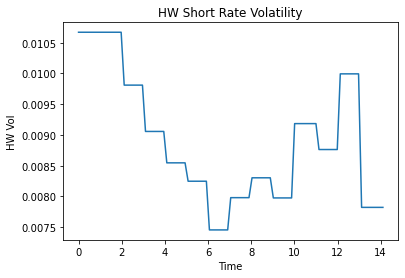

HW-1F Calibration Quality : 
------------------------------------
2Y/13Y Swaption Prices in Bps
Market (Normal) price : 549.0332
Hull & White 1F price : 549.0332
Calibration Error : 0.0000%
------------------------------------
3Y/12Y Swaption Prices in Bps
Market (Normal) price : 600.8958
Hull & White 1F price : 600.8958
Calibration Error : 0.0000%
------------------------------------
4Y/11Y Swaption Prices in Bps
Market (Normal) price : 606.0049
Hull & White 1F price : 606.0049
Calibration Error : 0.0000%
------------------------------------
5Y/10Y Swaption Prices in Bps
Market (Normal) price : 581.9454
Hull & White 1F price : 581.9454
Calibration Error : 0.0000%
------------------------------------
6Y/9Y Swaption Prices in Bps
Market (Normal) price : 547.6870
Hull & White 1F price : 547.6870
Calibration Error : 0.0000%
------------------------------------
7Y/8Y Swaption Prices in Bps
Market (Normal) price : 502.4079
Hull & White 1F price : 502.4079
Calibration Error : 0.0000%
-------

In [5]:
# IR yield curve asof 1st September 2023 (EURIBOR 6M)
maturities = np.array([0.5, 1, 2, 5, 10, 15, 20, 30])
zc_rates = np.array([3.94, 3.91, 3.57, 3.12, 3.06, 3.09, 2.97, 2.65]) / 100
yc = zc_curve(maturities, zc_rates)

# /!\ We calibrate the model using ATM vols. The prefered option would be to use skew vols at the Bermudan's strike level. 
# ATM Normal Market Volatilities asof 1st September 2023 (EURIBOR 6M)
atm_normal_vols = np.array([98.43, 95.76, 92.75, 89.99, 87.68, 85.05, 83.62, 82.83, 81.87, 82.22, 82.11, 83.11, 82.24]) / 10000
atm_strikes = np.array([3.05, 3.06, 3.086, 3.12, 3.146, 3.165, 3.2, 3.21, 3.197, 3.203, 3.184, 3.181, 3.181]) / 100

# Calibration to diagonal swaption set 2Y/13Y => 14Y/1Y
total_mat = 15
calib_set = []
i = 0
for expiry in range (2, total_mat) :
    tenor = total_mat - expiry
    swopt = swaption('payer', expiry, tenor, atm_strikes[i])
    swopt.set_market_data(yc.df, atm_normal_vols[i])
    calib_set.append(swopt)
    i += 1

# Create and calibrate the HW-1F model
mean_reversion = 0.015
hw = hw1f_model(mean_reversion)
hw.calibrate_sigma(calib_set)
print("HW-1F Calibrated Short Rate Vol : ")
hw.print()

# Print the calibration results
print("HW-1F Calibration Quality : ")
for swopt in calib_set :
    market_price = swopt.market_price()
    hw1f_price = hw.price(swopt)
    print("------------------------------------")
    print("{}Y/{}Y Swaption Prices in Bps".format(swopt.expiry, int(swopt.pay_times[-1]-swopt.start_time)))
    print("Market (Normal) price : {:.4f}".format(market_price))
    print("Hull & White 1F price : {:.4f}".format(hw1f_price))
    print("Calibration Error : {:.4f}%".format(100 * abs(market_price / hw1f_price - 1)))

To validate our Hull-White PDE implementation, we re-price the same set of diagonal swaptions used during the calibration phase. This allows us to verify that the PDE method correctly reproduces market prices for those instruments.

In [6]:
# PDE's params
nx = 601
nstdev = 5
dt = 0.05

print("PDE HW-1F Pricing Results :")

# Reprice all swaptions in calibration set using the PDE method
for swaption in calib_set: # in calib_set[3:4] to price only 5y/10y

    pde = hw1f_pde(yc.df, hw, nx, nstdev, dt, event_t = [swaption.expiry])

    def swaption_payoff(t, v_t, strike):
        if (math.isclose(t, swaption.expiry)):
            v_t = np.maximum(pde.pv_underlying(t, swaption, strike), 0.)
        return v_t

    pde_price = pde.compute_price(swaption_payoff, swaption.strike)
    market_price = swaption.market_price()

    print("------------------------------------")
    print("{}Y/{}Y Swaption Prices in Bps".format(swaption.expiry, int(swaption.pay_times[-1]-swaption.start_time)))
    print("PDE HW-1F price : {:.4f}".format(pde_price))
    print("Market (Normal) price : {:.4f}".format(market_price))
    print("Pricing Error : {:.4f}%".format(100 * abs(market_price / pde_price - 1)))

PDE HW-1F Pricing Results :
------------------------------------
2Y/13Y Swaption Prices in Bps
PDE HW-1F price : 549.0398
Market (Normal) price : 549.0332
Pricing Error : 0.0012%
------------------------------------
3Y/12Y Swaption Prices in Bps
PDE HW-1F price : 600.8946
Market (Normal) price : 600.8958
Pricing Error : 0.0002%
------------------------------------
4Y/11Y Swaption Prices in Bps
PDE HW-1F price : 605.9898
Market (Normal) price : 606.0049
Pricing Error : 0.0025%
------------------------------------
5Y/10Y Swaption Prices in Bps
PDE HW-1F price : 581.9498
Market (Normal) price : 581.9454
Pricing Error : 0.0008%
------------------------------------
6Y/9Y Swaption Prices in Bps
PDE HW-1F price : 547.6750
Market (Normal) price : 547.6870
Pricing Error : 0.0022%
------------------------------------
7Y/8Y Swaption Prices in Bps
PDE HW-1F price : 502.4073
Market (Normal) price : 502.4079
Pricing Error : 0.0001%
------------------------------------
8Y/7Y Swaption Prices in Bps
PD

With the model calibrated and validated, we are now ready to price the $15$-year Bermudan swaption :

In [7]:
print("15Y Annually Bermudan Swaption With No Call 2Y :")
print("------------------------------------------------")
# Set event_t = Calib swaptions expiries
event_t = []
for swaption in calib_set :
    event_t.append(swaption.expiry)

pde = hw1f_pde(yc.df, hw, nx, nstdev, dt, event_t)

# PayOff of bermudan swaption based upon the calibration set
def bermuda_payoff(t, v_t, strike):
    for swopt in calib_set:
        if (math.isclose(t, swopt.expiry)):
            v_t = np.maximum(pde.pv_underlying(t, swopt, strike), v_t)
            break
    return v_t

bermudan_strike = 3.35 / 100
bermudan_price = pde.compute_price(bermuda_payoff, bermudan_strike)
print("HW-1F Bermudan Swaption Price : {:.4f}".format(bermudan_price))
print("------------------------------------------------")

# Find most expensive swaption
swaptions_prices = np.empty(len(calib_set))
for i in range(len(calib_set)):
    calib_set[i].strike = bermudan_strike
    swaptions_prices[i] = calib_set[i].market_price()

imax = np.where(swaptions_prices == np.amax(swaptions_prices))[0][0]
max_swopt = calib_set[imax]
print("The most expensive underlying swaption is : {}Y/{}Y, and its Normal Price is : {:.4f}".format(max_swopt.expiry, int(max_swopt.pay_times[-1]-max_swopt.start_time), max_swopt.market_price()))

# Compute the switch option value
print("=> Switch option value : Bermudan Swaption Price - The Most Expensive Underlying Swaption Price = {:.4f}".format(bermudan_price - max_swopt.market_price()))

15Y Annually Bermudan Swaption With No Call 2Y :
------------------------------------------------
HW-1F Bermudan Swaption Price : 707.0190
------------------------------------------------
The most expensive underlying swaption is : 4Y/11Y, and its Normal Price is : 504.3106
=> Switch option value : Bermudan Swaption Price - The Most Expensive Underlying Swaption Price = 202.7084
